In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d omkargurav/face-mask-dataset

face-mask-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
from zipfile import ZipFile

data = '/content/face-mask-dataset.zip'

with ZipFile(data,'r') as zip:
  zip.extractall()
  print('The data has been extracted!')

The data has been extracted!


In [4]:
!ls

data  face-mask-dataset.zip  kaggle.json  mask.jpeg  no_mask.jpg  sample_data


In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mping
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
from sklearn.model_selection import train_test_split

In [6]:
with_mask_files = os.listdir('/content/data/with_mask')
print(len(with_mask_files))
print(with_mask_files[0:5])

3725
['with_mask_1894.jpg', 'with_mask_631.jpg', 'with_mask_218.jpg', 'with_mask_2634.jpg', 'with_mask_696.jpg']


In [7]:
without_mask_files = os.listdir('/content/data/without_mask')
print(len(without_mask_files))
print(without_mask_files[0:5])

3828
['without_mask_2943.jpg', 'without_mask_919.jpg', 'without_mask_2695.jpg', 'without_mask_1026.jpg', 'without_mask_1169.jpg']


Creating labels

with mask --> 1

without_mask --> 0

In [8]:
with_mask_labels = [1] * len(with_mask_files)
without_mask_labels = [0] * len(without_mask_files)

In [9]:
labels = with_mask_labels + without_mask_labels
print(len(labels))
print(labels[:5])
print(labels[-5:])

7553
[1, 1, 1, 1, 1]
[0, 0, 0, 0, 0]


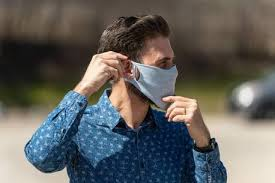

In [10]:
img = cv2.imread('/content/data/with_mask/with_mask_2590.jpg')
cv2_imshow(img)

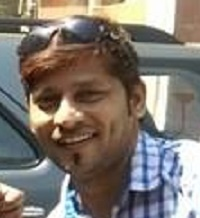

In [11]:
img2 = cv2.imread('/content/data/without_mask/without_mask_919.jpg')
cv2_imshow(img2)

In [12]:
data = []

for img_file in with_mask_files:
  image = Image.open('/content/data/with_mask/'+ img_file)
  image = image.resize((128,128))
  image = image.convert('RGB')  # precaution
  image = np.array(image)
  data.append(image)

for img_file in without_mask_files:
  image = Image.open('/content/data/without_mask/'+ img_file)
  image = image.resize((128,128))
  image = image.convert('RGB')  # precaution
  image = np.array(image)
  data.append(image)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


7553


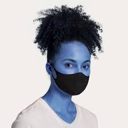

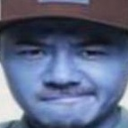

In [13]:
print(len(data))
cv2_imshow(data[50])
cv2_imshow(data[7000])

In [14]:
X = np.array(data)
Y = np.array(labels)

In [15]:
print(X.shape, Y.shape)

(7553, 128, 128, 3) (7553,)


In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 2)

In [17]:
print(X.shape, X_train.shape,Y_train.shape, X_test.shape)

(7553, 128, 128, 3) (6042, 128, 128, 3) (6042,) (1511, 128, 128, 3)


In [18]:
print('Number of 0 :',np.count_nonzero(Y_train == 0))
print('Number of 1 :',np.count_nonzero(Y_train == 1))

Number of 0 : 3060
Number of 1 : 2982


In [19]:
X_train = X_train/255
X_test = X_test/255

In [20]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [21]:
model = Sequential()

model.add(Conv2D(32, kernel_size =(3,3), activation='relu', input_shape=(128,128,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, kernel_size =(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        256       
 chNormalization)                                                
                                                        

In [22]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [23]:
history = model.fit(X_train, Y_train, validation_split=0.1, epochs = 5)

Epoch 1/5
170/170 [==============================] - 13s 33ms/step - loss: 0.3977 - accuracy: 0.8352 - val_loss: 0.9884 - val_accuracy: 0.5140
Epoch 2/5
170/170 [==============================] - 4s 25ms/step - loss: 0.2682 - accuracy: 0.8944 - val_loss: 0.6405 - val_accuracy: 0.6628
Epoch 3/5
170/170 [==============================] - 4s 25ms/step - loss: 0.2129 - accuracy: 0.9174 - val_loss: 0.2389 - val_accuracy: 0.9025
Epoch 4/5
170/170 [==============================] - 4s 25ms/step - loss: 0.1724 - accuracy: 0.9342 - val_loss: 0.2226 - val_accuracy: 0.9058
Epoch 5/5
170/170 [==============================] - 4s 26ms/step - loss: 0.1519 - accuracy: 0.9389 - val_loss: 0.2065 - val_accuracy: 0.9174


In [24]:
loss, accuracy = model.evaluate(X_test, Y_test)
print('Test Loss =',loss)
print('Test accuracy =',np.round(accuracy*100,3),'%')

48/48 [==============================] - 1s 11ms/step - loss: 0.2108 - accuracy: 0.9179
Test Loss = 0.2108008712530136
Test accuracy = 91.794 %


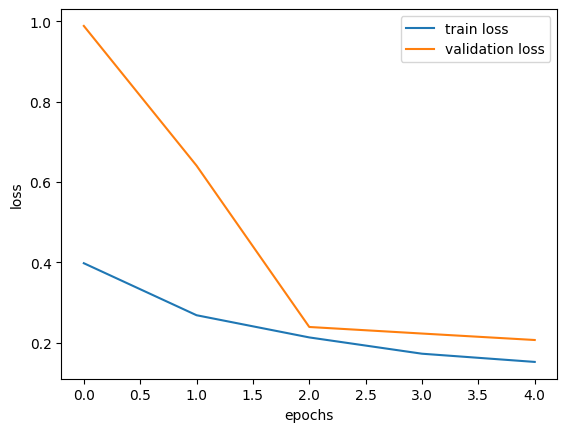

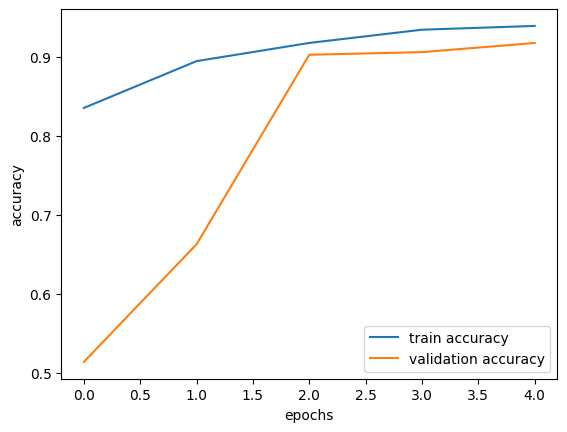

In [25]:
h = history

plt.plot(h.history['loss'], label = 'train loss')
plt.plot(h.history['val_loss'], label = 'validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
print('\n\n')
plt.plot(h.history['accuracy'], label = 'train accuracy')
plt.plot(h.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

Predictive System

Path of image to be predicted: /content/data/with_mask/with_mask_12.jpg


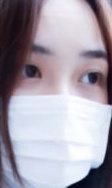

1/1 [==============================] - 0s 24ms/step
[[0.87524855]]
The person is wearing a mask!


In [38]:
input_image_path = input('Path of image to be predicted: ')
input_image = cv2.imread(input_image_path)
cv2_imshow(input_image)
input_image_resize = cv2.resize(input_image,(128,128))
input_image_scaled = input_image_resize/255
image_reshaped = np.reshape(input_image_scaled, [1,128,128,3])
input_prediction = model.predict(image_reshaped)
input_pred_label = 1 if input_prediction>=0.5 else 0
print(input_prediction)
print('The person is',('not wearing a mask!' if input_pred_label==0 else 'wearing a mask!'))